In [1]:
import pandas as pd
from sklearn import model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer

from scipy.spatial.distance import cosine
from keras.layers import *
from keras.regularizers import l2
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from math import sqrt
import os
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter
from collections import defaultdict
import seaborn as sns
from functools import reduce
import time

Using TensorFlow backend.


In [2]:
path = './procced/'
train_df = pd.read_csv(path+'train_ready.csv', encoding= 'ISO-8859-1')
test_df = pd.read_csv(path + 'test_ready.csv', encoding = 'ISO-8859-1')

In [3]:
train_df.head()

,id,product_uid,search_term,relevance,product_description,Brand_name,product_title_identity,product_desc_identity,product_brand_identity,product_title_length,product_desc_length
0,2,100001,angl bracket,3.00,simpson strong tie 12 gaug angl angl make join...,simpson strong tie,1.0,1.0,0.0,31.0,596.0
1,3,100001,l bracket,2.50,simpson strong tie 12 gaug angl angl make join...,simpson strong tie,0.0,0.0,0.0,31.0,596.0
2,9,100002,deck,3.00,behr premium textur deckov 1 gal. #sc 141 tugb...,behr premium textur deckov,0.0,1.0,0.0,67.0,783.0
3,16,100005,rain shower head,2.33,delta vero 1 handl shower faucet trim kit chro...,delta,1.0,1.0,0.0,64.0,487.0
4,17,100005,shower faucet,2.67,delta vero 1 handl shower faucet trim kit chro...,delta,2.0,2.0,0.0,64.0,487.0


In [4]:
test_df.head()

,id,product_uid,search_term,product_description,relevance,Usage,Brand_name,product_title_identity,product_desc_identity,product_brand_identity,product_title_length,product_desc_length
0,4,100001,metal l bracket,simpson strong tie 12 gaug angl angl make join...,2.33,Public,simpson strong tie,0.0,0.0,0.0,31.0,596.0
1,5,100001,simpson sku abl,simpson strong tie 12 gaug angl angl make join...,2.33,Private,simpson strong tie,1.0,1.0,1.0,31.0,596.0
2,6,100001,simpson strong tie,simpson strong tie 12 gaug angl angl make join...,2.67,Private,simpson strong tie,3.0,3.0,3.0,31.0,596.0
3,7,100001,simpson strong tie hcc668,simpson strong tie 12 gaug angl angl make join...,2.00,Public,simpson strong tie,3.0,3.0,3.0,31.0,596.0
4,10,100003,bath shower kit,sterl ensembl 33 1/4in. x 60in. x 75 1/4in. ba...,2.67,Private,sterl,3.0,1.0,0.0,82.0,513.0


## Charecter level preprocessing

Taking the search term and the product description and converting them to a list of characters

In [5]:
col_to_use = ['search_term','product_description']
target = 'relevance'

Y_train = train_df[target]
raw_X_train = train_df[col_to_use]

raw_X_test = test_df[col_to_use]
y_test = test_df[target]

In [6]:
def to_list(x):
    if type(x) == str:
        return list(x.lower())
    else:
        #print(x)
        return([])

In [7]:
raw_X_train['search_term'].map(to_list)
x = 2

In [8]:
raw_X_train['search_term'] = raw_X_train['search_term'].map(to_list)
raw_X_train['product_description'] = raw_X_train['product_description'].map(to_list)

raw_X_test['search_term'] = raw_X_test['search_term'].map(to_list)
raw_X_test['product_description'] = raw_X_test['product_description'].map(to_list)

raw_X_train.head()

C:\Users\vfqk84\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\vfqk84\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\vfqk84\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,search_term,product_description
0,"[a, n, g, l, , b, r, a, c, k, e, t]","[s, i, m, p, s, o, n, , s, t, r, o, n, g, , ..."
1,"[l, , b, r, a, c, k, e, t]","[s, i, m, p, s, o, n, , s, t, r, o, n, g, , ..."
2,"[d, e, c, k]","[b, e, h, r, , p, r, e, m, i, u, m, , t, e, ..."
3,"[r, a, i, n, , s, h, o, w, e, r, , h, e, a, d]","[d, e, l, t, a, , v, e, r, o, , 1, , h, a, ..."
4,"[s, h, o, w, e, r, , f, a, u, c, e, t]","[d, e, l, t, a, , v, e, r, o, , 1, , h, a, ..."


In [9]:
all_distinct_chars = raw_X_train['search_term'].values.tolist() + raw_X_train['product_description'].values.tolist()
all_distinct_chars = set(reduce(lambda acc,c: acc.union(set(c)),all_distinct_chars,set()))
print('number of disticnt chars in the train set: {}'.format(len(all_distinct_chars)))

number of disticnt chars in the train set: 68


In [10]:
def text_to_seq(tokenizer,df):
    ret_df = dict()
    ret_df['search_term'] = tokenizer.texts_to_sequences(df['search_term'].values)
    ret_df['product_description'] = tokenizer.texts_to_sequences(df['product_description'].values)
    return ret_df

    

In [11]:
tokenizer = Tokenizer(num_words=len(all_distinct_chars))
tokenizer.fit_on_texts(list(all_distinct_chars))

X_train = text_to_seq(tokenizer, raw_X_train)
X_test = text_to_seq(tokenizer, raw_X_test)

In [12]:
search_terms_lens = int(np.array([len(term) for term in X_train['search_term']]).mean())
produc_lens = int(np.array([len(p) for p in X_train['product_description']]).mean())

print('search terms sequences length: {}'.format(search_terms_lens))
print('product description sequences length: {}'.format(produc_lens))

search terms sequences length: 14
product description sequences length: 586


In [13]:
def pad_seq(data_df, df_name,search_terms_len,prod_desc_len):
    data_df['search_term'] = pad_sequences(data_df['search_term'],maxlen=search_terms_len)
    data_df['product_description'] = pad_sequences(data_df['product_description'],maxlen=prod_desc_len)
    print('{}[\'search_term\'].shape: {}'.format(df_name, data_df['search_term'].shape))
    print('{}[\'product_description\'].shape: {}\n'.format(df_name, data_df['product_description'].shape))

In [14]:
pad_seq(X_train,'X_train',search_terms_lens,int(produc_lens))
pad_seq(X_test,'X_test',search_terms_lens,int(produc_lens))

X_train['search_term'].shape: (74067, 14)
X_train['product_description'].shape: (74067, 586)

X_test['search_term'].shape: (112067, 14)
X_test['product_description'].shape: (112067, 586)



In [15]:
X_train['search_term'] = X_train['search_term'].reshape((X_train['search_term'].shape[0], X_train['search_term'].shape[1], 1))
X_train['product_description'] = X_train['product_description'].reshape((X_train['product_description'].shape[0], X_train['product_description'].shape[1], 1))
print('X_train search_term shape: {}'.format(X_train['search_term'].shape))
print('X_train product_description shape: {}\n'.format(X_train['product_description'].shape))

X_test['search_term'] = X_test['search_term'].reshape((X_test['search_term'].shape[0], X_test['search_term'].shape[1], 1))
X_test['product_description'] = X_test['product_description'].reshape((X_test['product_description'].shape[0], X_test['product_description'].shape[1], 1))
print('X_test search_term shape: {}'.format(X_test['search_term'].shape))
print('X_train product_description shape: {}'.format(X_test['product_description'].shape))

X_train search_term shape: (74067, 14, 1)
X_train product_description shape: (74067, 586, 1)

X_test search_term shape: (112067, 14, 1)
X_train product_description shape: (112067, 586, 1)


In [16]:
#hyper params:
lstm_n_hidden = 80
gradient_clipping_norm = 1.25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

def norm_to_1_3(m):
  return (m * 2) + 1 

In [17]:
trainend = int(len(train_df)*0.8)
counts = train_df.reset_index()[:trainend].groupby(['product_uid']).count()[['id']]

counts = counts[counts['id'] > 1]
counts = counts.add_suffix('_Count').reset_index()
valid_product_uids = set(counts['product_uid'].values)

inds = []

allowed_uids = train_df.reset_index().loc[train_df.reset_index()['product_uid'].isin(valid_product_uids)]
lastUid = 0

for idx, mrow in allowed_uids.iterrows():
    if lastUid == mrow['product_uid']:
        continue

    lastUid = mrow['product_uid']
    inds.append(idx)

test_inds = inds + list(train_df.reset_index()[trainend:].index.values)
train_inds = list(train_df.reset_index().loc[~train_df.reset_index().index.isin(test_inds)].index.values)

print("Train: "+str(len(train_inds))+", test: "+str(len(test_inds)))

Train: 48077, test: 25990


### Siamese NN

In [18]:
def rmse(actual,predicted):
    return sqrt(mse(actual,predicted))
def mae(actual,predicted):
    return MAE(actual,predicted)

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))  

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [88]:
def siamese():
    term_input = Input(shape=(search_terms_lens, 1), name='term_input')
    product_input = Input(shape=(produc_lens, 1), name='product_input')

    shared_lstm = Sequential(name='shared_model')
    shared_lstm.add(CuDNNLSTM(lstm_n_hidden))
    #shared_lstm.add(LSTM(lstm_n_hidden))
    shared_lstm.add(Dense(100, activation='relu'))
    shared_lstm.add(Dense(128, activation='relu',name='feature_extractor'))

    output = Lambda(function=lambda x: norm_to_1_3(exponent_neg_manhattan_distance(x[0], x[1])),
                    output_shape=lambda x: (x[0][0], 1),
                    name='prediction')([shared_lstm(term_input), shared_lstm(product_input)])

    model = Model(inputs=[term_input, product_input], outputs=[output])
    optimizer = Adadelta(clipnorm=gradient_clipping_norm)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae',root_mean_squared_error])
    return model

In [20]:
_columns=['Model type','runtime','Train RMSE','Val-RMSE','Test-RMSE','Train MAE','Val-MAE','Test-MAE']
results_table = pd.DataFrame(columns=_columns)

In [21]:


def update_result_table(model_type,runtime,train_pred,actual_train,val_pred,actual_val,test_pred,actual_test):
    global results_table
    train_rmse = rmse(actual_train, train_pred)  
    val_rmse = rmse(actual_val, val_pred)
    test_rmse = rmse(actual_test, test_pred)
    train_mae = mae(actual_train, train_pred) 
    val_mae = mae(actual_val, val_pred)
    test_mae = mae(actual_test, test_pred)
    print('train rmse: {},val rmse: {},test rmse: {},train mae: {},val mae: {}, test mae: {}'.format(train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae))
    results_table = results_table.append(pd.Series([model_type,runtime,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae], index = _columns),ignore_index=True)

In [89]:
from keras.callbacks import *

tests_path = './saved/reference'
def set_callbacks(description='run2',patience=17,tb_base_logdir='./logs/',model_num = ''):
    cp = ModelCheckpoint('./models/model' + model_num +'/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=False)
    es = EarlyStopping(patience=patience,monitor='val_loss')   
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss',factor=0.1, patience=5, verbose=1, epsilon=1e-3)
    cb = [cp,es,reduce_lr_loss]
    return cb

In [91]:
model = siamese()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term_input (InputLayer)         (None, 14, 1)        0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 586, 1)       0                                            
__________________________________________________________________________________________________
shared_model (Sequential)       (None, 128)          28628       term_input[0][0]                 
                                                                 product_input[0][0]              
__________________________________________________________________________________________________
prediction (Lambda)             (None, 1)            0           shared_model[1][0]               
          

In [92]:
training_start = time.time()
history = model.fit([X_train['search_term'][train_inds], X_train['product_description'][train_inds]], 
                                     Y_train.values[train_inds], 
                                     validation_data=[[X_train['search_term'][test_inds], X_train['product_description'][test_inds]], Y_train.values[test_inds]], 
                                     epochs=50, batch_size=1024, callbacks=set_callbacks(model_num = '_char_level_depper'))

end_time = time.time()
run_time = (end_time-training_start)/60
print('running time: {}'.format(run_time))

Train on 48077 samples, validate on 25990 samples
Epoch 1/50
48077/48077 [==============================] - 12s 251us/step - loss: 0.5176 - mean_absolute_error: 0.5786 - root_mean_squared_error: 0.5786 - val_loss: 0.3319 - val_mean_absolute_error: 0.4659 - val_root_mean_squared_error: 0.4659
Epoch 2/50
48077/48077 [==============================] - 11s 238us/step - loss: 0.2989 - mean_absolute_error: 0.4517 - root_mean_squared_error: 0.4517 - val_loss: 0.3041 - val_mean_absolute_error: 0.4431 - val_root_mean_squared_error: 0.4431
Epoch 3/50
48077/48077 [==============================] - 11s 238us/step - loss: 0.2890 - mean_absolute_error: 0.4441 - root_mean_squared_error: 0.4441 - val_loss: 0.2932 - val_mean_absolute_error: 0.4353 - val_root_mean_squared_error: 0.4353
Epoch 4/50
48077/48077 [==============================] - 11s 237us/step - loss: 0.2857 - mean_absolute_error: 0.4414 - root_mean_squared_error: 0.4414 - val_loss: 0.2986 - val_mean_absolute_error: 0.4397 - val_root_mean_

In [25]:
def predict_and_update_teble(model, time,title):
    train_prediction = model.predict([X_train['search_term'][train_inds], X_train['product_description'][train_inds]])
    valid_prediction = model.predict([X_train['search_term'][test_inds], X_train['product_description'][test_inds]])
    test_prediction = model.predict([X_test['search_term'],X_test['product_description']])
    update_result_table(title, time,
                       train_prediction, Y_train.values[train_inds],
                       valid_prediction, Y_train.values[test_inds],
                       test_prediction, y_test.values)
    return [train_prediction, valid_prediction, test_prediction]
    
def plot_model_history(model_history):
  fig, axs = plt.subplots(1,1,figsize=(15,5))
  axs.plot(range(1,len(model_history['loss'])+1),model_history['loss'])
  axs.plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
  axs.set_title('Model Loss')
  axs.set_ylabel('Loss')
  axs.set_xlabel('Epoch')
  axs.set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
  axs.legend(['train', 'val'], loc='best')
  plt.show()

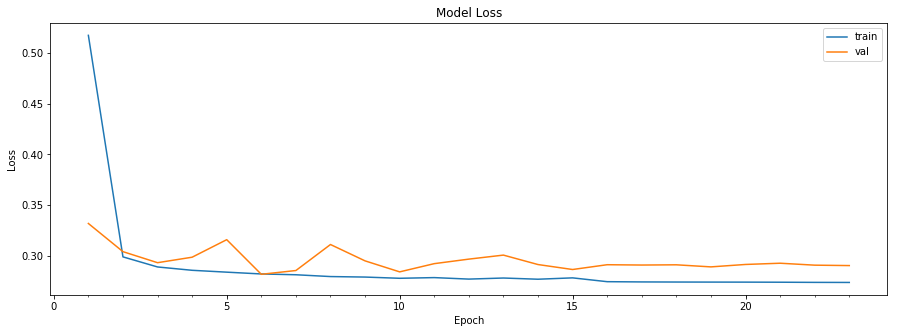

In [96]:
plot_model_history(history.history)

In [93]:
train_prediction = model.predict([X_train['search_term'][train_inds], X_train['product_description'][train_inds]])
valid_prediction = model.predict([X_train['search_term'][test_inds], X_train['product_description'][test_inds]])
test_prediction = model.predict([X_test['search_term'],X_test['product_description']])

In [94]:
update_result_table('_char_level_depper', run_time,
                       train_prediction, Y_train.values[train_inds],
                       valid_prediction, Y_train.values[test_inds],
                       test_prediction, y_test.values)

train rmse: 0.5231089339256657,val rmse: 0.5388363726231097,test rmse: 0.5341391361613422,train mae: 0.43164218671196347,val mae: 0.43226052447400126, test mae: 0.4355139274980197


In [30]:
results_table.head()

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.43627
1,6.54034,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.43627


## C 
Lets create a naive base model

In [31]:
mean=Y_train.values[train_inds].mean()

In [32]:
med = np.median(Y_train.values[train_inds])

In [33]:
update_result_table('mean', 0,
                       [mean]*len(Y_train.values[train_inds]), Y_train.values[train_inds],
                       [mean]*len(Y_train.values[test_inds]), Y_train.values[test_inds],
                       [mean]*len(y_test.values), y_test.values)

train rmse: 0.5315912592012845,val rmse: 0.5441691290539896,test rmse: 0.5374227080400054,train mae: 0.4422309624817527,val mae: 0.4395021344855421, test mae: 0.4418313151526855


In [34]:
update_result_table('median', 0,
                       [med]*len(Y_train.values[train_inds]), Y_train.values[train_inds],
                       [med]*len(Y_train.values[test_inds]), Y_train.values[test_inds],
                       [med]*len(y_test.values), y_test.values)

train rmse: 0.5838509475790149,val rmse: 0.6472946839339658,test rmse: 0.6085322713285541,train mae: 0.43905547351124236,val mae: 0.4953524432474028, test mae: 0.457977906074045


In [35]:
results_table.head()

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
1,6.54034,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978


## D 
Feature extraction

In [67]:
inter_model = Model(inputs = model.inputs,
                    outputs = model.layers[2].get_output_at(2))

In [68]:
inter_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
product_input (InputLayer)   (None, 586, 1)            0         
_________________________________________________________________
shared_model (Sequential)    (None, 128)               17128     
Total params: 17,128
Trainable params: 17,128
Non-trainable params: 0
_________________________________________________________________


In [70]:
train_features = inter_model.predict([X_train['search_term'][train_inds], X_train['product_description'][train_inds]])
valid_featurs = inter_model.predict([X_train['search_term'][test_inds], X_train['product_description'][test_inds]])
test_features = inter_model.predict([X_test['search_term'],X_test['product_description']])


In [71]:
min_max__features_scaler = preprocessing.MinMaxScaler()
min_max__features_scaler.fit(train_features)
train_features = preprocessing.scale(min_max__features_scaler.transform(train_features))
valid_featurs = preprocessing.scale(min_max__features_scaler.transform(valid_featurs))
test_features = preprocessing.scale(min_max__features_scaler.transform(test_features))

C:\Users\vfqk84\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\vfqk84\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\vfqk84\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encoun

### XGBoost
Lets take our features and train a regressor

In [72]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer


In [75]:
training_start_time = time.time()

xgb_model = xgb.XGBRegressor(n_estimators=400,learning_rate=0.01, max_depth=8, sub_sample=0.8,colsample_bytree=0.85, seed=1)
param_grid = {
        'n_estimators': [400],
        'learning_rate': [0.01, 0.001],
        'max_depth': [6, 8],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.8, 0.85]}

xgb_model = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=4, cv=2, verbose=2)

xgb_model.fit(train_features,Y_train.values[train_inds].ravel())

training_end_time = time.time()
print('running time: {}'.format((training_end_time-training_start_time)/60))


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7, total= 1.5min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.7, total= 1.5min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8, total= 1.5min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.8, total= 1.5min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7, total= 1.9min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7 
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7, total= 1.9min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 55.7min finished


running time: 59.69230476617813


In [76]:
train_prediction = xgb_model.predict(train_features)
valid_prediction = xgb_model.predict(valid_featurs)
test_prediction = xgb_model.predict(test_features)
update_result_table('XGBoost - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, Y_train.values[train_inds],
                   valid_prediction, Y_train.values[test_inds],
                   test_prediction, y_test.values)
results_table 


train rmse: 0.5052334351478802,val rmse: 0.5337577717874237,test rmse: 0.5342537672655845,train mae: 0.4200061508766027,val mae: 0.4287637829883322, test mae: 0.43784575735494996


,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
1,6.54034,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978
4,XGBoost - feature extracted,60,0.505233,0.533758,0.534254,0.420006,0.428764,0.437846


## Gradient Boosting

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

In [80]:
gbr_model = GradientBoostingRegressor(random_state=1, verbose=1)
param_grid = {
        'n_estimators': [500],
        'max_features': [8,10],
        'learning_rate': [0.1,0.01],
        'subsample': [0.8,0.7]
    }
training_start_time = time.time()
gbr_model = GridSearchCV(estimator=gbr_model, param_grid=param_grid, n_jobs=4, cv=3, verbose=20)
gbr_model.fit(train_features,Y_train.values[train_inds])
training_end_time = time.time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  1.1min
[Parallel(

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2809           0.0000           15.98s
         2           0.2827           0.0000           15.44s
         3           0.2822           0.0000           15.91s
         4           0.2818           0.0000           15.75s
         5           0.2834           0.0000           15.45s
         6           0.2802           0.0000           15.32s
         7           0.2814           0.0000           15.92s
         8           0.2813           0.0000           15.99s
         9           0.2822           0.0000           16.10s
        10           0.2787           0.0000           15.98s
        20           0.2807           0.0000           15.46s
        30           0.2817           0.0000           14.91s
        40           0.2840           0.0000           14.66s
        50           0.2792           0.0000           14.23s
        60           0.2826           0.0000           13.83s
       

In [81]:
train_prediction = gbr_model.predict(train_features)
valid_prediction = gbr_model.predict(valid_featurs)
test_prediction = gbr_model.predict(test_features)
update_result_table('GradientBoostingRegressor - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, Y_train.values[train_inds],
                   valid_prediction, Y_train.values[test_inds],
                   test_prediction, y_test.values)
results_table 

train rmse: 0.5277528599342745,val rmse: 0.5428286614185074,test rmse: 0.5364930105703051,train mae: 0.4380801972247594,val mae: 0.4375832661878638, test mae: 0.4400690444569062


,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
1,6.54034,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978
4,XGBoost - feature extracted,60,0.505233,0.533758,0.534254,0.420006,0.428764,0.437846
5,GradientBoostingRegressor - feature extracted,2,0.527753,0.542829,0.536493,0.438080,0.437583,0.440069


## Gradient Boosting 

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
rfr_model = RandomForestRegressor(random_state=1, verbose=1)
param_grid = {'n_estimators': [500], 'max_features': [10, 12, 14]}
rfr_model = GridSearchCV(estimator=rfr_model, param_grid=param_grid, n_jobs=4, cv=3, verbose=20)

training_start_time = time.time()
rfr_model.fit(train_features,Y_train.values[train_inds].ravel())

training_end_time = time.time()
print('running time: {}'.format((training_end_time-training_start_time)/60))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:  1.4min remaining:  2.8min
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:  1.5min remaining:  1.9min
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:  2.6min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:  2.6min remaining:  1.3min
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:  2.9min remaining:   49.7s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


running time: 5.421234484513601


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.2min finished


In [85]:
train_prediction = rfr_model.predict(train_features)
valid_prediction = rfr_model.predict(valid_featurs)
test_prediction = rfr_model.predict(test_features)
update_result_table('RandomForest - feature extracted', 
                   round((training_end_time-training_start_time)/60), 
                   train_prediction, Y_train.values[train_inds],
                   valid_prediction, Y_train.values[test_inds],
                   test_prediction, y_test.values)
results_table 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


train rmse: 0.28096172992736157,val rmse: 0.5447445123109733,test rmse: 0.556197045785204,train mae: 0.21189135195058792,val mae: 0.43677542978508505, test mae: 0.45162979114787594


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.0s finished


,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
1,6.54034,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978
4,XGBoost - feature extracted,60,0.505233,0.533758,0.534254,0.420006,0.428764,0.437846
5,GradientBoostingRegressor - feature extracted,2,0.527753,0.542829,0.536493,0.438080,0.437583,0.440069
6,RandomForest - feature extracted,5,0.280962,0.544745,0.556197,0.211891,0.436775,0.451630


In [86]:
t = results_table.drop(index=1)
t

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978
4,XGBoost - feature extracted,60,0.505233,0.533758,0.534254,0.420006,0.428764,0.437846
5,GradientBoostingRegressor - feature extracted,2,0.527753,0.542829,0.536493,0.438080,0.437583,0.440069
6,RandomForest - feature extracted,5,0.280962,0.544745,0.556197,0.211891,0.436775,0.451630


In [95]:
results_table

,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,_final_char_leve_emmbedings,6.54034,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
1,6.54034,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978
4,XGBoost - feature extracted,60,0.505233,0.533758,0.534254,0.420006,0.428764,0.437846
5,GradientBoostingRegressor - feature extracted,2,0.527753,0.542829,0.536493,0.438080,0.437583,0.440069
6,RandomForest - feature extracted,5,0.280962,0.544745,0.556197,0.211891,0.436775,0.451630
7,_char_level_depper,4.40744,0.523109,0.538836,0.534139,0.431642,0.432261,0.435514


In [97]:
results_table.to_csv('./q1_res.csv',)

In [98]:
t = pd.read_csv('./q1_res.csv')
t

,Unnamed: 0,Model type,runtime,Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
0,0,_final_char_leve_emmbedings,6.540339068571726,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
1,1,6.540339068571726,_final_char_leve_emmbedings,0.523769,0.539189,0.534762,0.432266,0.432609,0.436270
2,2,mean,0,0.531591,0.544169,0.537423,0.442231,0.439502,0.441831
3,3,median,0,0.583851,0.647295,0.608532,0.439055,0.495352,0.457978
4,4,XGBoost - feature extracted,60,0.505233,0.533758,0.534254,0.420006,0.428764,0.437846
5,5,GradientBoostingRegressor - feature extracted,2,0.527753,0.542829,0.536493,0.438080,0.437583,0.440069
6,6,RandomForest - feature extracted,5,0.280962,0.544745,0.556197,0.211891,0.436775,0.451630
7,7,_char_level_depper,4.407435746987661,0.523109,0.538836,0.534139,0.431642,0.432261,0.435514
